In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from pandas.api.types import CategoricalDtype
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
ds = pd.read_csv('preprocessed_mean.csv')

In [ ]:
ds.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,46.367100,0.340399,0.545596,2.592875e+05,0.561824,0.253581,0.189415,-10.674001,0.102728,118.201869,0.398924
std,16.554067,0.380775,0.204310,1.338799e+05,0.296470,0.365628,0.157082,7.892410,0.109077,28.904267,0.252902
min,0.000000,0.000001,0.060000,1.550900e+04,0.000792,0.000000,0.015700,-47.046000,0.022400,34.347000,0.000000
25%,34.000000,0.018400,0.400750,1.978385e+05,0.343000,0.000000,0.094700,-13.274000,0.038500,95.447500,0.180000
50%,50.000000,0.141000,0.566000,2.367330e+05,0.629000,0.002170,0.122000,-7.624500,0.051200,120.154137,0.373000
75%,58.000000,0.726000,0.704000,2.886735e+05,0.805000,0.605250,0.235000,-5.333750,0.116000,137.382250,0.590000
max,96.000000,0.996000,0.986000,4.830606e+06,0.999000,0.994000,0.991000,1.585000,0.932000,220.041000,0.992000


In [ ]:
ds.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
valence             float64
music_genre          object
dtype: object

In [ ]:
#Separamos los datos de entrenamiento de los de test y asignamos a cada variable su tipo

Y = ds['music_genre']
X = ds.drop(labels='music_genre', axis = 1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=33)

categorical = []
numerical = []

for cat in X.columns:
  if ds[cat].dtype == object: categorical.append(cat)
  else: numerical.append(cat)

X_train_categorical = X_train[categorical].astype(CategoricalDtype())
X_test_categorical = X_test[categorical].astype(CategoricalDtype())
X_train_numerical =  X_train[numerical].astype('float64')
X_test_numerical = X_test[numerical].astype('float64')

In [ ]:
X_train_numerical[numerical] = X_train_numerical[numerical].apply(pd.to_numeric, errors='coerce')
X_test_numerical[numerical] = X_test_numerical[numerical].apply(pd.to_numeric, errors='coerce')
X_train_numerical.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object

# NB Categorico * NB Gaussiano

In [ ]:
#Standarizamos los Datos
scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_train_numerical)
X_test_num_std = scaler.transform(X_test_numerical)

In [ ]:
#Entrenamos Gaussian Naive Bayes sobre los datos numerales
gaussian_nb = GaussianNB()

gaussian_nb.fit(X_train_num_std,Y_train)

gaussian_nb.score(X_test_num_std, Y_test)

0.82625

In [ ]:
def preprocessing_categorical(X):
    for c in X.columns:
        X[c]=X[c].cat.codes
    return X

In [ ]:
X_train_categorical = preprocessing_categorical(X_train_categorical)
X_test_categorical = preprocessing_categorical(X_test_categorical)

In [ ]:
#Entrenamos Categorical Naive Bayes sobre los datos categoricos
cat_nb = CategoricalNB()

cat_nb.fit(X_train_categorical,Y_train)

cat_nb.score(X_test_categorical,Y_test)

0.34575

In [ ]:
#Combinamos las predicciones multiplicando las probabilidades de ser de cada clase obtenidas por los dos modelos
combined_prediction_proba= cat_nb.predict_proba(X_test_categorical) * gaussian_nb.predict_proba(X_test_num_std)
combined_prediction = np.argmax(combined_prediction_proba,axis=1)
clases = {1:'Electronic',3:'Rock',0:'Classical',2:'Hip-Hop'}
combined_prediction = [clases[v] for v in combined_prediction]

In [ ]:
accuracy_score(combined_prediction, Y_test)

0.829

In [ ]:
print(classification_report(Y_test,combined_prediction))

              precision    recall  f1-score   support

   Classical       0.91      0.92      0.91       955
  Electronic       0.85      0.75      0.80      1057
     Hip-Hop       0.76      0.88      0.82       995
        Rock       0.81      0.78      0.79       993

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



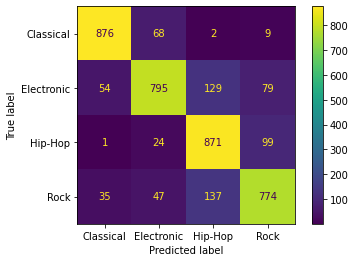

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,combined_prediction)

# One Hot + Gaussian NB

In [ ]:
#Realizamos One Hot Encoding Sobre las Variables Categoricas
ds = pd.get_dummies(ds, columns=categorical)

In [ ]:
#Separamos los datos y realizamos la particion en Train y Test
Y = ds['music_genre']
X = ds.drop(labels='music_genre', axis = 1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=33)

In [ ]:
#Standarizamos los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Entrenamos Gaussian Naive Bayes
gaussian_nb = GaussianNB()

gaussian_nb.fit(X_train,Y_train)

gaussian_nb.score(X_test, Y_test)

0.7865

In [ ]:
prediction = np.argmax(gaussian_nb.predict_proba(X_test),axis=1)
clases = {1:'Electronic',3:'Rock',0:'Classical',2:'Hip-Hop'}
prediction = [clases[v] for v in prediction]

In [ ]:
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

   Classical       0.90      0.92      0.91       955
  Electronic       0.86      0.73      0.79      1057
     Hip-Hop       0.69      0.84      0.75       995
        Rock       0.73      0.67      0.70       993

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



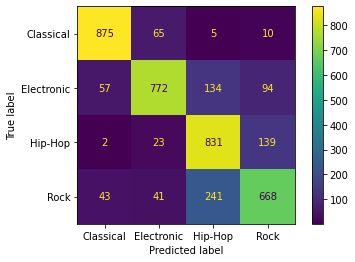

In [ ]:
ConfusionMatrixDisplay.from_predictions(Y_test,prediction)